In [1]:
import mne
from scipy.io import loadmat
import numpy as np

In [2]:
def file_to_data(fileName):
    chnames = ['Fp1','Fp2','Fc5','Fz','Fc6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
    chtypes = ['eeg'] * 16 + ['stim']
    info = mne.create_info(ch_names=chnames, sfreq=512,ch_types=chtypes, montage='standard_1020',verbose=False)
    data = loadmat(fileName)["SIGNAL"]
    #On modifie pour avoir un dataset avec 1 : yeux ouvert et -1 yeux fermée
    new_data=[]
    yeux_ouvert=False
    for k in range(len(data)):
        if(yeux_ouvert==False):
            tmp=np.append(data[k][1:17],-1)
        else:
            tmp=np.append(data[k][1:17],1)
        new_data.append(tmp)
        if(data[k][17]==1):
            yeux_ouvert=True
        if(data[k][18]==1):
            yeux_ouvert=False
    labels= [d[16] for d in new_data]
    donnees = [d[:16] for d in new_data]
    return donnees,labels

In [3]:
donnees,labels = file_to_data("data/subject_01.mat")

In [4]:
import pyriemann
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

[0, 1]
[0.         0.84147098]
[ 0.84147098+0.j -0.84147098+0.j]


/home/nicolas/envPythonML/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


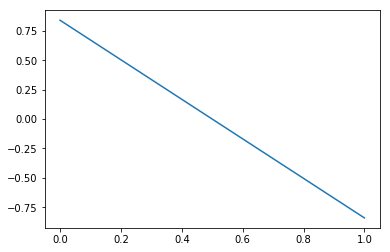

In [5]:
sp = np.fft.fft(donnees[:][0])
#plt.plot(sp)
t = list(range(2))
print(t)
sinus = np.sin(t)
print(sinus)
sp = np.fft.fft(sinus)
print(sp)
plt.plot(sp)

In [72]:
from numpy.fft import fft,fftfreq
from scipy.signal import spectrogram, hanning

def spectre(signal):
    _ , _,s = spectrogram(signal)
    s=s[:,0]
    return s
def estimate_tf(matrice):
    new_mat=[]
    #matrice=np.swapaxes(matrice,0,1)
    for ligne in matrice:
        new_mat.append(spectre(ligne))
    return new_mat
def estimate_mult_matrice(data):
    new_mat=[]
    for matrice in data:
        new_mat.append(estimate_tf(matrice))
    return new_mat

In [73]:
def cross_val_tf_perceptron(donnees,labels,nb_trail):
    nb_paquet=int(len(donnees)/nb_trail)
    donnees = donnees[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees), nb_paquet))#Ntrial*Nchannels*Nsample
    X=np.swapaxes(X,1,2)
    #estimer la matrice de covariance
    tf_data = np.array(estimate_mult_matrice(X))
    print(tf_data.shape)
    tf_data=tf_data.reshape((tf_data.shape[0],tf_data.shape[1]*tf_data.shape[2]))
    print(tf_data.shape)
    #validation croisée
    clf = SGDClassifier(loss="perceptron", eta0=1e-4, learning_rate="constant", penalty=None,tol=1e-1,max_iter=10000,shuffle=True)
    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels = labels[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels), nb_paquet))
    Y=[]
    for u in yTemp:
        if(np.mean(u)>0):
            Y.append(1)
        else:
            Y.append(-1)
    Y=np.array(Y)
    y_pred = cross_val_predict(clf,tf_data,Y,cv=5)
    rapport = classification_report(Y, y_pred,output_dict=True)
    return rapport['micro avg']["f1-score"]

In [74]:
#512 Hz
#On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
#On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
tab_trail=[]
result_f1Score=[]
#1 secondes -> 512 paquets
#100ms=0,1s -> 51,2 paquets -> 51 paquets
#10ms=0,01s -> 5,12 paquets -> 5 paquets
for nb_trail in [512,51,18]:
    print(nb_trail)
    tab_trail.append(nb_trail)
    f1Score = cross_val_tf_perceptron(donnees,labels,nb_trail)
    result_f1Score.append(f1Score)
    print("F1 Score riemann : "+str(f1Score))

512
(234, 16, 129)
(234, 2064)
F1 Score riemann : 0.43162393162393164
51


/home/nicolas/envPythonML/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  .format(nperseg, input_length))


(2349, 16, 26)
(2349, 416)
F1 Score riemann : 0.6564495530012772
18


/home/nicolas/envPythonML/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 18, using nperseg = 18
  .format(nperseg, input_length))


(6656, 16, 10)
(6656, 160)
F1 Score riemann : 0.6654146634615384


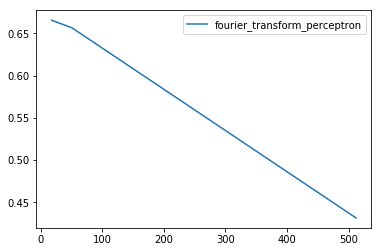

In [75]:
plt.plot(tab_trail,result_f1Score,label="fourier_transform_perceptron")
plt.legend()
plt.show()